In [1]:
import numpy as np
import time as t
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import FormatStrFormatter

In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.
    ###设置图形尺寸，避免在 LaTeX 中缩放

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
            ###以点为单位的文档宽度，或预定文档类型的字符串
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
            ###您希望图形所占宽度的分数
    subplots: array-like, optional
            The number of rows and columns of subplots.
            ###子绘图的行数和列数。
    Returns
    -------
    fig_dim: tuple
            ### The primary difference is that we cannot modify a tuple once it is created.
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width
    ### 确定文档的类型从而选择生成图片区域的大小

    # Width of figure (in pts)
    # 图标在区域中占的宽度，并转换为英寸的单位
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # 0.618

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)
# plt.rcParams.update()，其中 update 是 rcParams 对象的一个方法，用于更新 Matplotlib 的运行时配置参数。

In [3]:

def coef_ctrlloop(rl, eps, lam, tl, nn, al, kl):
    N = len(rl)
    hr = rl[1]-rl[0]

    # 定义常数
    c1 = eps * tl / (2 * hr**2)
    c2 = eps * tl / (4 * hr)
    c3 = tl * lam / 2
    c4 = eps * tl * nn**2 / 2
    # 第一行系数
    a1 = 1 + 2 * c1 - c3[0] + 4 * c4 / (hr**2)
    a2 = -c1 - 2 * c2 / hr
    a3 = 1 - 2 * c1 + c3[0] - 4 * c4 / (hr**2)
    a4 = c1 + 2 * c2 / hr

    # 计算控制系数
    Atc_n = -1/2 * al *kl
    Atc_n[0][-1] = -Atc_n[0][-1]/2 +1
    Ac_n = 1/2 * al *kl
    

    # 初始化系数矩阵的稀疏结构
    data_at = [a1,a2]
    column_at = [0,1]
    offset_at = [0]

    data_a = [a3,a4]
    column_a = [0,1]
    offset_a = [0]

    rrl = rl[1:-1]

    # 定义系数的坐标
    # I_m0 = np.arange(1, N-1) # 生成从第二个点到倒数第二个点的坐标 对角线
    # I_l0 = np.arange(0, N-2) # for i-1
    # I_r0 = np.arange(2,N) # for i+1

    #构建At矩阵系数
    At_1 = -(c1 * np.ones(N-2)) + c2 / rrl   # for i-1
    At_2 = (1 + 2 * c1) * np.ones(N-2) - c3[1:-1] + c4 / (rrl**2)  # for i
    At_3 = -c1 * np.ones(N-2) - c2 / rrl 

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_at.append(len(data_at))
        # 第一部分下对角线
        data_at.append(At_1[i-1])
        column_at.append(i-1)

        # 第二部分对角线
        data_at.append(At_2[i-1])
        column_at.append(i)

        # 第三部分上对角线
        data_at.append(At_3[i-1])
        column_at.append(i+1)
    
    # 定义边界条件
    offset_at.append(len(data_at)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    
    for i in range(0,N):
        data_at.append(Atc_n[0][i])
        column_at.append(i)
    
    offset_at.append(len(data_at)) # 行偏移向量中的最后一个元素是非零元素的个数

    # 构建At矩阵
    At = csr_matrix((data_at, column_at, offset_at), shape=(N, N))

    # 构建A矩阵系数
    A_1 = c1 * np.ones(N-2) - c2 / rrl
    A_2 = (1 - 2 * c1) * np.ones(N-2) + c3[1:-1] - c4 / (rrl**2)
    A_3 = c1 * np.ones(N-2) + c2 / rrl

    #对于每一行，记录非零元素的列索引和对应值
    for i in range(1,N-1):
        # 记录行偏移位置
        offset_a.append(len(data_a))
        # 第一部分下对角线
        data_a.append(A_1[i-1])
        column_a.append(i-1)

        # 第二部分对角线
        data_a.append(A_2[i-1])
        column_a.append(i)

        # 第三部分上对角线
        data_a.append(A_3[i-1])
        column_a.append(i+1)
    
    # 定义边界条件
    offset_a.append(len(data_a)) # 最后一行的第一个元素是即将添加的第一个元素，该元素在data中的索引为data的长度。data长度为n则下一个元素的索引为n(实际为第n+1的元素)
    
    for i in range(0,N):
        data_a.append(Ac_n[0][i])
        column_a.append(i)

    offset_a.append(len(data_a)) # 行偏移向量中的最后一个元素是非零元素的个数

    A = csr_matrix((data_a, column_a, offset_a), shape=(N, N))

    # print("data_at:", data_at)
    # print("column_at:", column_at)
    # print("offset_at:", offset_at)
    # print(c1)
    # print(c2)
    # print(c3)
    # print(c4)

    return(At, A)

# 生成用于求解复合辛普森积分的系数序列
def ComSimpson(N, hr):
    # hr = delta_r
    c = np.ones((1,N))*2
    # 在matlab中 c(2:2:N-1)=4
    # 比如 C[行索引, 1:n:2] 就会涉及到对特定行中按照列维度进行这样的切片选取并赋值操作了，和这里介绍的一维数组切片赋值在维度上有差异。
    # 下面的0，表示选取第一个维度的所有元素, 1:n:2 表示选取第二个维度的1到n-1的元素，步长为2
    c[0,1:N-1:2] = 4
    c[0,0] = 1
    c[0,N-1] = 1
    c = hr/3*c
    return c

# 计算kernel(注意分不同情况)
def getK(r, n):
    M = len(r)
    x, y = np.meshgrid(r, r)
  
    if n == 0:
        kernel = (-35 / 54) * x ** 6 * y + (-155 / 4536) * x ** 10 * y + (-635 / 762048) * x ** 14 * y + \
                 (-35 / 6) * x ** 4 * y ** 3 + (-3875 / 4536) * x ** 8 * y ** 3 + (-635 / 15552) * x ** 12 * y ** 3 + \
                 (5 / 2) * x ** 2 * y ** 5 + (-4075 / 2268) * x ** 6 * y ** 5 + (-10235 / 36288) * x ** 10 * y ** 5 + \
                 (215 / 54) * y ** 7 + (10625 / 2268) * x ** 4 * y ** 7 + (54125 / 326592) * x ** 8 * y ** 7 + \
                 (-1775 / 4536) * x ** 2 * y ** 9 + (60125 / 46656) * x ** 6 * y ** 9 + \
                 (-7295 / 4536) * y ** 11 + (-1895 / 1344) * x ** 4 * y ** 11 + (-15665 / 326592) * x ** 2 * y ** 13 + \
                 (748105 / 2286144) * y ** 15 + (1 / 6) * ((-20) * x ** 2 * y + (-20) * y ** 3)
    elif n in [1, -1]:
        kernel = x ** (-1) * y ** 2 * ((-20 / 3) * x ** 2 + (-20 / 9) * x ** 6 + (-100 / 567) * x ** 10 + (-10 / 1701) * x ** 14 +
                                      (-20 / 3) * x ** 4 * y ** 2 + (-1000 / 567) * x ** 8 * y ** 2 + (-10 / 81) * x ** 12 * y ** 2 +
                                      (80 / 9) * x ** 2 * y ** 4 + (100 / 567) * x ** 6 * y ** 4 + (-550 / 1701) * x ** 10 * y ** 4 +
                                      (3200 / 567) * x ** 4 * y ** 6 + (4750 / 5103) * x ** 8 * y ** 6 + (-2200 / 567) * x ** 2 * y ** 8 +
                                      (800 / 1701) * x ** 6 * y ** 8 + (-3040 / 1701) * x ** 4 * y ** 10 + (4280 / 5103) * x ** 2 * y ** 12)
    elif n in [2, -2]:
        kernel = x ** (-2) * y ** 3 * ((-85 / 18) * x ** 6 + (-2285 / 4536) * x ** 10 + (-16435 / 762048) * x ** 14 +
                                      (-85 / 18) * x ** 4 * y ** 2 + (-11425 / 4536) * x ** 8 * y ** 2 + (-82175 / 326592) * x ** 12 * y ** 2 +
                                      (25 / 2) * x ** 2 * y ** 4 + (7675 / 2268) * x ** 6 * y ** 4 + (-13625 / 108864) * x ** 10 * y ** 4 +
                                      (-55 / 18) * y ** 6 + (8675 / 2268) * x ** 4 * y ** 6 + (169175 / 108864) * x ** 8 * y ** 6 +
                                      (-125 / 24) * x ** 2 * y ** 8 + (-291325 / 326592) * x ** 6 * y ** 8 + (515 / 504) * y ** 10 +
                                      (-18185 / 15552) * x ** 4 * y ** 10 + (625 / 576) * x ** 2 * y ** 12 +
                                      (-45575 / 254016) * y ** 14 + (1 / 2) * ((-20) * x ** 2 + (20 / 3) * y ** 2))
    elif n in [3, -3]:
        kernel = x ** (-3) * y ** 4 * ((-220 / 27) * x ** 6 + (-620 / 567) * x ** 10 + (-2050 / 35721) * x ** 14 +
                                      (-1550 / 567) * x ** 8 * y ** 2 + (-2050 / 5103) * x ** 12 * y ** 2 +
                                      (40 / 3) * x ** 2 * y ** 4 + (4000 / 567) * x ** 6 * y ** 4 + (10 / 27) * x ** 10 * y ** 4 +
                                      (-140 / 27) * y ** 6 + (8800 / 5103) * x ** 8 * y ** 6 + (-100 / 21) * x ** 2 * y ** 8 +
                                      (-11600 / 5103) * x ** 6 * y ** 8 + (290 / 189) * y ** 10 + (500 / 567) * x ** 2 * y ** 12 +
                                      (-970 / 3969) * y ** 14 + (1 / 2) * ((-80 / 3) * x ** 2 + (40 / 3) * y ** 2))
    elif n in [4, -4]:
        kernel = x ** (-4) * y ** 5 * ((-25 / 2) * x ** 6 + (-9175 / 4536) * x ** 10 + (-287825 / 2286144) * x ** 14 +
                                      (15 / 2) * x ** 4 * y ** 2 + (-9175 / 4536) * x ** 8 * y ** 2 + (-57565 / 108864) * x ** 12 * y ** 2 +
                                      (205 / 18) * x ** 2 * y ** 4 + (125 / 12) * x ** 6 * y ** 4 + (125935 / 108864) * x ** 10 * y ** 4 +
                                      (-115 / 18) * y ** 6 + (-425 / 84) * x ** 4 * y ** 6 + (404525 / 326592) * x ** 8 * y ** 6 +
                                      (-1475 / 504) * x ** 2 * y ** 8 + (-625 / 192) * x ** 6 * y ** 8 + (7325 / 4536) * y ** 10 +
                                      (16225 / 12096) * x ** 4 * y ** 10 + (2065 / 5184) * x ** 2 * y ** 12 +
                                      (-57215 / 254016) * y ** 14 + (1 / 2) * ((-100 / 3) * x ** 2 + 20 * y ** 2))
    elif n in [5, -5]:
        kernel = x ** (-5) * y ** 6 * ((-160 / 9) * x ** 6 + (-1910 / 567) * x ** 10 + (-2890 / 11907) * x ** 14 +
                                      (160 / 9) * x ** 4 * y ** 2 + (-2890 / 5103) * x ** 12 * y ** 2 +
                                      (20 / 3) * x ** 2 * y ** 4 + (800 / 63) * x ** 6 * y ** 4 + (3680 / 1701) * x ** 10 * y ** 4 +
                                      (-20 / 3) * y ** 6 + (-2000 / 189) * x ** 4 * y ** 6 + (-50 / 567) * x ** 2 * y ** 8 +
                                      (-2000 / 567) * x ** 6 * y ** 8 + (760 / 567) * y ** 10 + (160 / 63) * x ** 4 * y ** 10 +
                                      (-370 / 1701) * x ** 2 * y ** 12 + (-5330 / 35721) * y ** 14 + (1 / 2) * ((-40) * x ** 2 + (80 / 3) * y ** 2))
    elif n in [6, -6]:
        kernel = x ** (-6) * y ** 7 * ((-1295 / 54) * x ** 6 + (-125 / 24) * x ** 10 + (-139295 / 326592) * x ** 14 +
                                      (185 / 6) * x ** 4 * y ** 2 + (625 / 168) * x ** 8 * y ** 2 + (-139295 / 326592) * x ** 12 * y ** 2 +
                                      (-5 / 6) * x ** 2 * y ** 4 + (9925 / 756) * x ** 6 * y ** 4 + (625 / 192) * x ** 10 * y ** 4 +
                                      (-325 / 54) * y ** 6 + (-35825 / 2268) * x ** 4 * y ** 6 + (-71875 / 36288) * x ** 8 * y ** 6 +
                                      (15275 / 4536) * x ** 2 * y ** 8 + (-104725 / 36288) * x ** 6 * y ** 8 + (3575 / 4536) * y ** 10 +
                                      (121355 / 36288) * x ** 4 * y ** 10 + (-274105 / 326592) * x ** 2 * y ** 12 +
                                      (-13225 / 326592) * y ** 14 + (1 / 2) * ((-140 / 3) * x ** 2 + (100 / 3) * y ** 2))
    elif n in [7, -7]:
        kernel = x ** (-7) * y ** 8 * ((-280 / 9) * x ** 6 + (-160 / 21) * x ** 10 + (-24970 / 35721) * x ** 14 +
                                      (140 / 3) * x ** 4 * y ** 2 + (200 / 21) * x ** 8 * y ** 2 + (-100 / 9) * x ** 2 * y ** 4 +
                                      (6200 / 567) * x ** 6 * y ** 4 + (800 / 189) * x ** 10 * y ** 4 + (-40 / 9) * y ** 6 +
                                      (-11300 / 567) * x ** 4 * y ** 6 + (-2600 / 567) * x ** 8 * y ** 6 + (4000 / 567) * x ** 2 * y ** 8 +
                                      (-100 / 81) * x ** 6 * y ** 8 + (20 / 567) * y ** 10 + (6070 / 1701) * x ** 4 * y ** 10 +
                                      (-6950 / 5103) * x ** 2 * y ** 12 + (950 / 11907) * y ** 14 + (1 / 2) * ((-160 / 3) * x ** 2 + 40 * y ** 2))
    else:
        kernel = np.zeros((M, M), dtype=np.complex128)
    
    # 建立索引
    mask = x - y < 0
    # 按索引赋值，索引为mask中的元素（即下三角区域）赋值为nan
    kernel[mask] = np.nan
    # 取最后一列，并转置
    k_bud = kernel[:,-1].T
    # k_bud = np.conjugate(k_bud)
    return k_bud, kernel


def getKcomplex(r, n):
    M = len(r)
    x, y = np.meshgrid(r, r)
    if n==0:
        kernel = (y * ((-2 / 3) * x ** 4 + (35 / 96) * x ** 6 + (1j * (-65 / 504)) * x ** 8 + ((-11 / 945) + 1j * (155 / 10752)) * x ** 10 +
                                        (157 / 24192) * x ** 12 + ((-635 / 2408448) + 1j * (-179 / 174636)) * x ** 14 + (-8 / 3) * x ** 2 * y ** 2 +
                                        (105 / 32) * x ** 4 * y ** 2 + (1j * (-130 / 63)) * x ** 6 * y ** 2 + ((-55 / 189) + 1j * (3875 / 10752)) * x ** 8 * y ** 2 +
                                        (157 / 672) * x ** 10 * y ** 2 + ((-635 / 49152) + 1j * (-179 / 3564)) * x ** 12 * y ** 2 + (-2 / 3) * y ** 4 +
                                        (-45 / 32) * x ** 2 * y ** 4 + (1j * (-95 / 28)) * x ** 4 * y ** 4 + ((-220 / 189) + 1j * (4075 / 5376)) * x ** 6 * y ** 4 +
                                        (3275 / 2688) * x ** 8 * y ** 4 + ((-10235 / 114688) + 1j * (-265 / 616)) * x ** 10 * y ** 4 + (-215 / 96) * y ** 6 +
                                        (1j * (220 / 63)) * x ** 2 * y ** 6 + ((-80 / 189) + 1j * (-10625 / 5376)) * x ** 4 * y ** 6 + (125 / 3024) * x ** 6 * y ** 6 +
                                        ((54125 / 1032192) + 1j * (-40375 / 49896)) * x ** 8 * y ** 6 + (1j * (1055 / 504)) * y ** 8 +
                                        ((295 / 189) + 1j * (1775 / 10752)) * x ** 2 * y ** 8 + (-9725 / 2688) * x ** 4 * y ** 8 +
                                        ((60125 / 147456) + 1j * (6400 / 6237)) * x ** 6 * y ** 8 + ((311 / 945) + 1j * (7295 / 10752)) * y ** 10 +
                                        (33 / 32) * x ** 2 * y ** 10 + ((-51165 / 114688) + 1j * (367 / 198)) * x ** 4 * y ** 10 + (26293 / 24192) * y ** 12 +
                                        ((-15665 / 1032192) + 1j * (-54349 / 49896)) * x ** 2 * y ** 12 + ((748105 / 7225344) + 1j * (-174565 / 349272)) * y ** 14 +
                                        0.5 * ((1j * (-5)) * x ** 2 + (1j * (-5)) * y ** 2)))
    elif n in [1, -1]:
        kernel= (x ** (-1) * y ** 2 * ((1j * (-5)) * x ** 2 + (-2) * x ** 4 + (5 / 4) * x ** 6 + (1j * (-25 / 42)) * x ** 8 +
                                       ((-17 / 252) + 1j * (25 / 336)) * x ** 10 + (1 / 24) * x ** 12 + ((-5 / 2688) + 1j * (-65 / 8316)) * x ** 14 +
                                       (-2) * x ** 2 * y ** 2 + (15 / 4) * x ** 4 * y ** 2 + (1j * (-25 / 7)) * x ** 6 * y ** 2 +
                                       ((-85 / 126) + 1j * (125 / 168)) * x ** 8 * y ** 2 + (5 / 8) * x ** 10 * y ** 2 +
                                       ((-5 / 128) + 1j * (-65 / 396)) * x ** 12 * y ** 2 + (-5) * x ** 2 * y ** 4 +
                                       (1j * (-15 / 14)) * x ** 4 * y ** 4 + ((-85 / 63) + 1j * (-25 / 336)) * x ** 6 * y ** 4 +
                                       (75 / 56) * x ** 8 * y ** 4 + ((-275 / 2688) + 1j * (-8165 / 11088)) * x ** 10 * y ** 4 +
                                       (1j * (110 / 21)) * x ** 2 * y ** 6 + ((125 / 126) + 1j * (-50 / 21)) * x ** 4 * y ** 6 +
                                       (-325 / 168) * x ** 6 * y ** 6 + ((2375 / 8064) + 1j * (-2575 / 8316)) * x ** 8 * y ** 6 +
                                       ((277 / 252) + 1j * (275 / 168)) * x ** 2 * y ** 8 + (-20 / 7) * x ** 4 * y ** 8 +
                                       ((25 / 168) + 1j * (11675 / 5544)) * x ** 6 * y ** 8 + (39 / 14) * x ** 2 * y ** 10 +
                                       ((-95 / 168) + 1j * (35 / 66)) * x ** 4 * y ** 10 + ((535 / 2016) + 1j * (-15725 / 11088)) * x ** 2 * y ** 12))
    elif n in [2, -2]:
        kernel = (x ** (-2) * y ** 3 * ((-4) * x ** 4 + (85 / 32) * x ** 6 + (1j * (-45 / 28)) * x ** 8 + ((-2 / 9) + 1j * (2285 / 10752)) * x ** 10 +
                                       (65 / 448) * x ** 12 + ((-16435 / 2408448) + 1j * (-89 / 2772)) * x ** 14 + (85 / 32) * x ** 4 * y ** 2 +
                                       (1j * (-30 / 7)) * x ** 6 * y ** 2 + ((-10 / 9) + 1j * (11425 / 10752)) * x ** 8 * y ** 2 +
                                       (65 / 56) * x ** 10 * y ** 2 + ((-82175 / 1032192) + 1j * (-445 / 1188)) * x ** 12 * y ** 2 +
                                       (-225 / 32) * x ** 2 * y ** 4 + (1j * (15 / 7)) * x ** 4 * y ** 4 + ((-10 / 9) + 1j * (-7675 / 5376)) * x ** 6 * y ** 4 +
                                       (75 / 112) * x ** 8 * y ** 4 + ((-13625 / 344064) + 1j * (-725 / 792)) * x ** 10 * y ** 4 +
                                       (55 / 32) * y ** 6 + (1j * 5) * x ** 2 * y ** 6 + ((22 / 9) + 1j * (-8675 / 5376)) * x ** 4 * y ** 6 +
                                       (-1195 / 336) * x ** 6 * y ** 6 + ((169175 / 344064) + 1j * (1315 / 1848)) * x ** 8 * y ** 6 +
                                       (1j * (-5 / 4)) * y ** 8 + (1j * (1125 / 512)) * x ** 2 * y ** 8 + (-395 / 448) * x ** 4 * y ** 8 +
                                       ((-291325 / 1032192) + 1j * (365 / 154)) * x ** 6 * y ** 8 + (1j * (-1545 / 3584)) * y ** 10 +
                                       (345 / 112) * x ** 2 * y ** 10 + ((-18185 / 49152) + 1j * (-431 / 462)) * x ** 4 * y ** 10 +
                                       (-415 / 672) * y ** 12 + ((5625 / 16384) + 1j * (-25 / 24)) * x ** 2 * y ** 12 +
                                       ((-45575 / 802816) + 1j * (325 / 1512)) * y ** 14 + 0.5 * ((1j * (-15)) * x ** 2 + (1j * 5) * y ** 2)))
    elif n in [3, -3]:
        kernel = (x ** (-3) * y ** 4 * ((-20 / 3) * x ** 4 + (55 / 12) * x ** 6 + (1j * (-425 / 126)) * x ** 8 +
                                       ((-209 / 378) + 1j * (155 / 336)) * x ** 10 + (565 / 1512) * x ** 12 +
                                       ((-1025 / 56448) + 1j * (-33505 / 349272)) * x ** 14 +
                                       (10 / 3) * x ** 2 * y ** 2 + (1j * (-425 / 126)) * x ** 6 * y ** 2 +
                                       ((-1045 / 756) + 1j * (775 / 672)) * x ** 8 * y ** 2 + (565 / 336) * x ** 10 * y ** 2 +
                                       ((-1025 / 8064) + 1j * (-33505 / 49896)) * x ** 12 * y ** 2 +
                                       (-2 / 3) * y ** 4 + (-15 / 2) * x ** 2 * y ** 4 + (1j * 5) * x ** 4 * y ** 4 +
                                       ((-209 / 378) + 1j * (-125 / 42)) * x ** 6 * y ** 4 + (-95 / 112) * x ** 8 * y ** 4 +
                                       ((15 / 128) + 1j * (-2201 / 2772)) * x ** 10 * y ** 4 +
                                       (35 / 12) * y ** 6 + (1j * (65 / 18)) * x ** 2 * y ** 6 + (100 / 27) * x ** 4 * y ** 6 +
                                       (-1565 / 378) * x ** 6 * y ** 6 + ((275 / 504) + 1j * (200455 / 99792)) * x ** 8 * y ** 6 +
                                       (1j * (-235 / 126)) * y ** 8 + ((-275 / 189) + 1j * (225 / 112)) * x ** 2 * y ** 8 +
                                       (75 / 56) * x ** 4 * y ** 8 + ((-725 / 1008) + 1j * (81815 / 49896)) * x ** 6 * y ** 8 +
                                       ((181 / 756) + 1j * (-145 / 224)) * y ** 10 +
                                       (835 / 336) * x ** 2 * y ** 10 + (1j * (-35 / 18)) * x ** 4 * y ** 10 + (-385 / 432) * y ** 12 +
                                       ((125 / 448) + 1j * (-895 / 2268)) * x ** 2 * y ** 12 +
                                       ((-485 / 6272) + 1j * (16007 / 63504)) * y ** 14 +
                                       0.5 * ((1j * (-20)) * x ** 2 + (1j * 10) * y ** 2)))
    elif n in [4, -4]:
        kernel = (x ** (-4) * y ** 5 * ((-10) * x ** 4 + (225 / 32) * x ** 6 + (1j * (-1025 / 168)) * x ** 8 +
                                        ((-73 / 63) + 1j * (9175 / 10752)) * x ** 10 + (2155 / 2688) * x ** 12 +
                                        ((-287825 / 7225344) + 1j * (-13675 / 58212)) * x ** 14 +
                                        8 * x ** 2 * y ** 2 + (-135 / 32) * x ** 4 * y ** 2 +
                                        ((-73 / 63) + 1j * (9175 / 10752)) * x ** 8 * y ** 2 + (431 / 224) * x ** 10 * y ** 2 +
                                        ((-57565 / 344064) + 1j * (-2735 / 2772)) * x ** 12 * y ** 2 +
                                        (-2) * y ** 4 + (-205 / 32) * x ** 2 * y ** 4 + (1j * (25 / 4)) * x ** 4 * y ** 4 +
                                        (1j * (-1125 / 256)) * x ** 6 * y ** 4 + (-8095 / 2688) * x ** 8 * y ** 4 +
                                        ((125935 / 344064) + 1j * (-485 / 1848)) * x ** 10 * y ** 4 +
                                        (115 / 32) * y ** 6 + (1j * (40 / 21)) * x ** 2 * y ** 6 +
                                        ((100 / 21) + 1j * (3825 / 1792)) * x ** 4 * y ** 6 + (-375 / 112) * x ** 6 * y ** 6 +
                                        ((404525 / 1032192) + 1j * (18055 / 5544)) * x ** 8 * y ** 6 +
                                        (1j * (-115 / 56)) * y ** 8 + ((-65 / 21) + 1j * (4425 / 3584)) * x ** 2 * y ** 8 +
                                        (2775 / 896) * x ** 4 * y ** 8 + (-16875 / 16384) * x ** 6 * y ** 8 +
                                        ((41 / 63) + 1j * (-7325 / 10752)) * y ** 10 +
                                        (985 / 672) * x ** 2 * y ** 10 +
                                        ((48675 / 114688) + 1j * (-275 / 126)) * x ** 4 * y ** 10 +
                                        (-2497 / 2688) * y ** 12 +
                                        ((2065 / 16384) + 1j * (325 / 1512)) * x ** 2 * y ** 12 +
                                        ((-57215 / 802816) + 1j * (7565 / 38808)) * y ** 14 +
                                        0.5 * ((1j * (-25)) * x ** 2 + (1j * 15) * y ** 2)))
    elif n in [5, -5]:
        kernel = (x ** (-5) * y ** 6 * ((-14) * x ** 4 + 10 * x ** 6 + (1j * (-10)) * x ** 8 +
                                        ((-389 / 180) + 1j * (955 / 672)) * x ** 10 + (73 / 48) * x ** 12 +
                                        ((-1445 / 18816) + 1j * (-309 / 616)) * x ** 14 +
                                        14 * x ** 2 * y ** 2 + (-10) * x ** 4 * y ** 2 + (1j * (20 / 3)) * x ** 6 * y ** 2 +
                                        (73 / 48) * x ** 10 * y ** 2 + ((-1445 / 8064) + 1j * (-103 / 88)) * x ** 12 * y ** 2 +
                                        (-4) * y ** 4 + (-15 / 4) * x ** 2 * y ** 4 + (1j * (65 / 14)) * x ** 4 * y ** 4 +
                                        (1j * (-75 / 14)) * x ** 6 * y ** 4 + (-75 / 14) * x ** 8 * y ** 4 +
                                        ((115 / 168) + 1j * (2425 / 3696)) * x ** 10 * y ** 4 +
                                        (15 / 4) * y ** 6 + (1j * (5 / 7)) * x ** 2 * y ** 6 +
                                        ((35 / 6) + 1j * (125 / 28)) * x ** 4 * y ** 6 + (-25 / 21) * x ** 6 * y ** 6 +
                                        (1j * (25 / 6)) * x ** 8 * y ** 6 + (1j * (-85 / 42)) * y ** 8 +
                                        ((-175 / 36) + 1j * (25 / 672)) * x ** 2 * y ** 8 + (1325 / 336) * x ** 4 * y ** 8 +
                                        ((-125 / 112) + 1j * (-125 / 54)) * x ** 6 * y ** 8 +
                                        ((107 / 90) + 1j * (-95 / 168)) * y ** 10 +
                                        (43 / 112) * x ** 2 * y ** 10 + ((45 / 56) + 1j * (-769 / 504)) * x ** 4 * y ** 10 +
                                        (-23 / 28) * y ** 12 + ((-185 / 2688) + 1j * (6463 / 11088)) * x ** 2 * y ** 12 +
                                        ((-2665 / 56448) + 1j * (445 / 4158)) * y ** 14 +
                                        0.5 * ((1j * (-30)) * x ** 2 + (1j * 20) * y ** 2)))
    elif n in [6, -6]:
        kernel = (x ** (-6) * y ** 7 * ((-56 / 3) * x ** 4 + (1295 / 96) * x ** 6 + (1j * (-275 / 18)) * x ** 8 +
                                        ((-100 / 27) + 1j * (1125 / 512)) * x ** 10 + (2281 / 864) * x ** 12 +
                                        ((-139295 / 1032192) + 1j * (-12085 / 12474)) * x ** 14 +
                                        (64 / 3) * x ** 2 * y ** 2 + (-555 / 32) * x ** 4 * y ** 2 + (1j * (1100 / 63)) * x ** 6 * y ** 2 +
                                        ((500 / 189) + 1j * (-5625 / 3584)) * x ** 8 * y ** 2 +
                                        ((-139295 / 1032192) + 1j * (-12085 / 12474)) * x ** 12 * y ** 2 +
                                        (-20 / 3) * y ** 4 + (15 / 32) * x ** 2 * y ** 4 + (1j * (-15 / 14)) * x ** 4 * y ** 4 +
                                        ((-250 / 189) + 1j * (-9925 / 1792)) * x ** 6 * y ** 4 + (-1375 / 192) * x ** 8 * y ** 4 +
                                        ((16875 / 16384) + 1j * (125 / 72)) * x ** 10 * y ** 4 +
                                        (325 / 96) * y ** 6 + (1j * (55 / 63)) * x ** 2 * y ** 6 +
                                        ((1390 / 189) + 1j * (35825 / 5376)) * x ** 4 * y ** 6 + (5975 / 3024) * x ** 6 * y ** 6 +
                                        ((-71875 / 114688) + 1j * (20875 / 4536)) * x ** 8 * y ** 6 +
                                        (1j * (-125 / 63)) * y ** 8 + ((-1286 / 189) + 1j * (-15275 / 10752)) * x ** 2 * y ** 8 +
                                        (155 / 42) * x ** 4 * y ** 8 + ((-104725 / 114688) + 1j * (-11425 / 2268)) * x ** 6 * y ** 8 +
                                        ((346 / 189) + 1j * (-3575 / 10752)) * y ** 10 +
                                        (-169 / 336) * x ** 2 * y ** 10 + ((121355 / 114688) + 1j * (5 / 308)) * x ** 4 * y ** 10 +
                                        (-7765 / 12096) * y ** 12 + ((-274105 / 1032192) + 1j * (4175 / 7128)) * x ** 2 * y ** 12 +
                                        ((-13225 / 1032192) + 1j * (1745 / 49896)) * y ** 14 +
                                        0.5 * ((1j * (-35)) * x ** 2 + (1j * 25) * y ** 2)))
    elif n in [7, -7]:
        kernel = (x ** (-7) * y ** 8 * ((-24) * x ** 4 + (35 / 2) * x ** 6 + (1j * (-155 / 7)) * x ** 8 +
                                        ((-125 / 21) + 1j * (45 / 14)) * x ** 10 + (30 / 7) * x ** 12 +
                                        ((-12485 / 56448) + 1j * (-33623 / 19404)) * x ** 14 +
                                        30 * x ** 2 * y ** 2 + (-105 / 4) * x ** 4 * y ** 2 + (1j * (465 / 14)) * x ** 6 * y ** 2 +
                                        ((625 / 84) + 1j * (-225 / 56)) * x ** 8 * y ** 2 + (-45 / 14) * x ** 10 * y ** 2 +
                                        (-10) * y ** 4 + (25 / 4) * x ** 2 * y ** 4 + (1j * (-85 / 7)) * x ** 4 * y ** 4 +
                                        ((-625 / 126) + 1j * (-775 / 168)) * x ** 6 * y ** 4 + (-625 / 84) * x ** 8 * y ** 4 +
                                        ((75 / 56) + 1j * (625 / 252)) * x ** 10 * y ** 4 +
                                        (5 / 2) * y ** 6 + (1j * (45 / 14)) * x ** 2 * y ** 6 +
                                        ((629 / 63) + 1j * (2825 / 336)) * x ** 4 * y ** 6 + (305 / 56) * x ** 6 * y ** 6 +
                                        ((-325 / 224) + 1j * (14195 / 3024)) * x ** 8 * y ** 6 +
                                        (1j * (-15 / 7)) * y ** 8 + ((-1145 / 126) + 1j * (-125 / 42)) * x ** 2 * y ** 8 +
                                        (135 / 56) * x ** 4 * y ** 8 + ((-25 / 64) + 1j * (-11065 / 1386)) * x ** 6 * y ** 8 +
                                        ((649 / 252) + 1j * (-5 / 336)) * y ** 10 +
                                        (-25 / 24) * x ** 2 * y ** 10 + ((3035 / 2688) + 1j * (1879 / 792)) * x ** 4 * y ** 10 +
                                        (-25 / 56) * y ** 12 + ((-3475 / 8064) + 1j * (655 / 4158)) * x ** 2 * y ** 12 +
                                        ((475 / 18816) + 1j * (925 / 77616)) * y ** 14 +
                                        0.5 * ((1j * (-40)) * x ** 2 + (1j * 30) * y ** 2)))
    else:
        kernel = np.zeros((M, M), dtype=np.complex128)
    
    # 建立索引
    mask = x - y < 0
    # 按索引赋值，索引为mask中的元素（即下三角区域）赋值为nan
    kernel[mask] = np.nan
    # 取最后一列，并转置
    k_bud = kernel[:,-1].T
    k_bud = np.conjugate(k_bud)
    return k_bud, kernel

def solveKernelFunction(delta_r, r, lam, n, eps, c):
    # 考虑复数的情况下使用
    # k = np.zeros((len(lam), len(lam)), dtype=complex)
    k = np.zeros((len(lam), len(lam)))
    a = lam

    # FD LOOP
    k[1][1] = -(((a[0]+a[1])/2+c)/(2*eps))*delta_r
    for i in range(1, len(lam)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i] - ((((a[i+1]+a[i])/2)+c)/(2*eps))*delta_r
        k[i+1][i] = k[i][i] - ((a[i+1]+c)/(2*eps))*delta_r
        for j in range(1, i):
            # k[i+1][j] = ((-k[i-1][j] + k[i][j+1] + k[i][j-1] - (delta_r/r[i])*(k[i][j] - k[i-1][j]) - (delta_r/r[j])*(k[i][j]-k[i][j-1])) + (((n**2)*(r[j]**2 - r[i]**2) + r[i]**2)/(r[j]**2 * r[i]**2) + ((a[j] + c) / eps)) * (k[i][j+1] + k[i][j-1]) * (delta_r**2/2))
            k[i+1][j] = (((-k[i-1][j] + k[i][j+1] + k[i][j-1] - (delta_r/(2*r[i+1]))*(k[i-1][j]) - (delta_r/(2*r[j+1]))*(k[i][j+1]-k[i][j-1])) + (((n**2)*(r[j+1]**2 - r[i+1]**2) + r[i+1]**2)/(r[j+1]**2 * r[i+1]**2) + ((a[j+1] + c) / eps)) * (k[i][j+1] + k[i][j-1]) * (delta_r**2/2)))/(1 + (delta_r/(2*r[i+1])))
    
    k_bud = k[-1,:]
    return  k_bud , k

In [6]:
# initial
R_max = 1
eps = 1 # diffusion coefficient

# for time
final_time = 0.5
t_step = 0.0005
Max_step = int(final_time/t_step) # calculate the number of time steps
time = np.arange(0,final_time+t_step,t_step) 
time = time[1:]
ratio = 1
# time for draw
time1 = time[::ratio] # 切片（slicing）语法，提取time数组中的元素，提出每隔ratio个元素的子集
Rstep1 = time[1] - time[0]
Max_step1 = len(time1)
# for sptial
N = 91
delta_r = (2*R_max)/(2*(N-1)+1)
r = np.arange(1, N+1, dtype=np.float64) # 生成左闭右开的范围，步长默认为1
r = (r- 1/2)*delta_r

# random condition (can be changed)
n = 6 # power of fourier series
lamda1 = 50*r**2
lamda = 40 - 20*np.cos(np.pi*r)
# lamda = 40*r**4+30*1j*r**2

# uu = np.zeros((N,Max_step1))

In [7]:
# 计算控制增益
c = 1
a = ComSimpson(N, delta_r)
[K, kernel] = getK(r, n)
[K1, kernel1] = solveKernelFunction(delta_r, r, lamda, n, eps, c)

# 计算At和A矩阵
# [At, A] = coef_ctrlloop(r, eps, lamda, t_step, n, a, K)
[At, A] = coef_ctrlloop(r, eps, lamda, t_step, n, a, K1)

# 输出 At 和 A 矩阵的稀疏格式
# print("At matrix (CSR format):")
# print(At)
# print("\nA matrix (CSR format):")
# print(A)

In [8]:
# initial
u = np.zeros((N, Max_step1)) 
u_inital = 2 * np.ones(N)
u_inital[-1] = 0
u[:,0] = u_inital

In [9]:
# 计算u_open
R = A @ u_inital
ratio = 1
# 定义时间步循环
sn = 1
for i in range(1, Max_step1):
    u2 = spsolve(At, R)
    R = A @ u2 # 更新等式右边 R
    if i % ratio == 0:
        u[:,sn] = u2
        sn +=1

u_squared = u**2
error = np.sum(u_squared, axis=0)

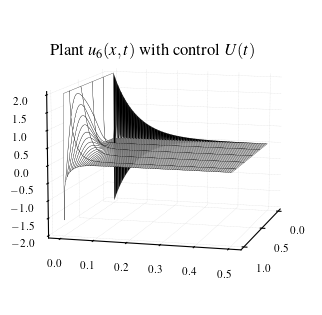

In [10]:
# 初始设置与图形创建
# fig = plt.figure(figsize=set_size(1024, 0.49, (1,2), height_add=0.5))
# subfigs = fig.subfigures(nrows=1, ncols=2, width_ratios=[1, 1], height_ratios=[1])
# subfig0 = subfigs[0]
# subfig1 = subfigs[1]
fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))
subfigs = fig.subfigures(nrows=1, ncols=1)
subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(fr"Plant $u_{n}(x, t)$ with control $U(t)$")
# subfig0.subplots_adjust(left=0.07, bottom=0, right=1, top=0.9)
# subfig1.subplots_adjust(left=0.15, bottom=0, right=1, top=0.9)
# subfig0.suptitle(r"Plant $u(x, t)$ with openloop $U(t)=0$")
# subfig0.suptitle(r"$\|\mathbf{u}(t,r)\|_{L^2}$")

axes0 = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
# axes0.set_title(r"Plant $u(x, t)$ with openloop $U(t)=0$")

for axis in [axes0.xaxis, axes0.yaxis, axes0.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(r, time1)
uopen = u.transpose()

                     
axes0.plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=10, cstride=20, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes0.view_init(10, 15)
axes0.zaxis.set_rotate_label(False)
axes0.set_xticks([0, 0.5, 1])
axes0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# axes1 = subfig1.subplots(nrows=1, ncols=1)
# # axes1.set_title(r"$\|\mathbf{u}(t,r)\|_{L^2}$")
# axes1.plot(time1, error, 'm.-', label='Error')
# axes1.set_xlabel('Time (sec)')
# axes1.set_ylabel(r'$|| \mathbf{u}(t,r) ||_{L^2}$')


# folder_path = r"F:\Program\MASs\simulate\code_radially_varying\code_radially_varying\un\result"
# # folder_path = r"E:\Python_Program\code_radially_varying\code_radially_varying\un\result"
# os.makedirs(folder_path, exist_ok=True)
# save_path = os.path.join(folder_path, f"control_loop{n}.pdf")
# plt.savefig(save_path, dpi=300)


Text(0.5, 1.0, 'Plant $u_6(x, t)$ control error in $L^2$')

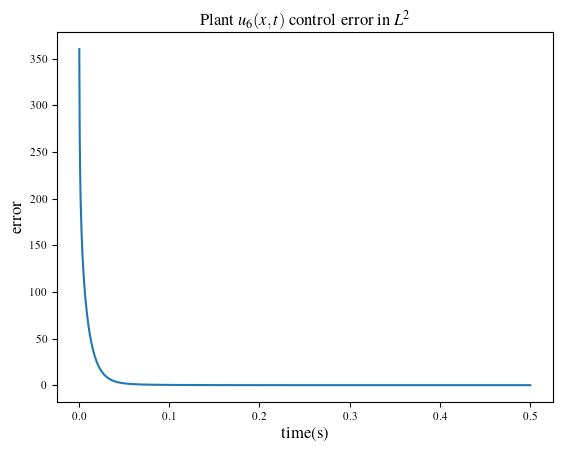

In [11]:
fig = plt.figure()
plt.plot(time1, error)
plt.xlabel('time(s)', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.title(fr"Plant $u_{n}(x, t)$ control error in $L^2$")

# folder_path = r"F:\Program\MASs\simulate\code_radially_varying\code_radially_varying\un\result"
# # folder_path = r"E:\Python_Program\code_radially_varying\code_radially_varying\un\result"
# os.makedirs(folder_path, exist_ok=True)
# save_path = os.path.join(folder_path, f"error_L^2_control_{n}.pdf")
# plt.savefig(save_path, dpi=300)